In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, model, label_encoder=None, max_length=512):
        """
        Args:
            texts: pandas Series or list of texts
            labels: list of label lists
            model: SBERT model
            label_encoder: MultiLabelBinarizer instance (optional)
            max_length: maximum sequence length
        """
        # Convert texts to list if it's a pandas Series
        self.texts = texts.tolist() if isinstance(texts, pd.Series) else texts
        
        # Initialize or use provided label encoder
        if label_encoder is None:
            self.label_encoder = MultiLabelBinarizer()
            self.labels = self.label_encoder.fit_transform(labels)
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(labels)
        
        self.model = model
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # Now a binary numpy array
        
        # Access tokenizer correctly, handling DataParallel wrapper
        actual_model = self.model.module if isinstance(self.model, torch.nn.DataParallel) else self.model
        tokenizer = actual_model._first_module().tokenizer

        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)
        }

class FineTunedSBERT(SentenceTransformer):
    def __init__(self, model_name='all-mpnet-base-v2', num_labels=20):
        super().__init__(model_name)
        for param in self.parameters():
            param.requires_grad = False
        
        for layer in self._first_module().auto_model.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        for param in self._first_module().auto_model.pooler.parameters():
            param.requires_grad = True
            
        hidden_size = self._first_module().auto_model.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100):
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame")
    
    df = df.dropna()
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])

    label_distribution = Counter([label for labels in labels for label in labels])
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    texts = texts[length_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[length_mask].reset_index(drop=True)
    
    return texts, filtered_labels

def get_embeddings(texts, model, batch_size=32):
    # Determine the actual model and device, handling DataParallel
    actual_model = model.module if isinstance(model, torch.nn.DataParallel) else model
    actual_model.eval() # Set the underlying model to evaluation mode
    device = next(actual_model.parameters()).device

    # Use the original model (potentially wrapped) for the forward pass if using multiple GPUs
    # DataParallel handles the distribution automatically
    inference_model = model if isinstance(model, torch.nn.DataParallel) else actual_model
    if isinstance(inference_model, torch.nn.DataParallel):
        print(f"Using {torch.cuda.device_count()} GPUs for embedding generation!")

    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size].tolist()
            
            # Use tokenizer from the actual_model
            tokenizer = actual_model._first_module().tokenizer
    
            encoding = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=actual_model.max_seq_length, # Use actual model's max_seq_length
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Directly get embeddings from the base transformer model's output
            # If using DataParallel (inference_model is wrapped), it will handle the multi-GPU forward pass
            # We access the underlying module's auto_model to get the correct output structure
            base_transformer = actual_model._first_module().auto_model
            outputs = base_transformer(input_ids=input_ids, attention_mask=attention_mask)

            pooled_output = outputs.pooler_output
            
            embeddings.append(pooled_output.cpu().numpy())
    
    return np.vstack(embeddings)

def calculate_similarities(test_embeddings, train_embeddings, similarity_metric='cosine'):
    """
    Calculate similarities between test and train embeddings using different metrics.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        similarity_metric: one of 'cosine', 'euclidean', 'jaccard'
        
    Returns:
        similarities: numpy array of shape (n_test, n_train)
    """
    if similarity_metric == 'cosine':
        return cosine_similarity(test_embeddings, train_embeddings)
    
    elif similarity_metric == 'euclidean':
        # Convert distances to similarities (higher is more similar)
        distances = euclidean_distances(test_embeddings, train_embeddings)
        max_dist = np.max(distances)
        if max_dist == 0:
            return np.ones_like(distances)
        return 1 - (distances / max_dist)
    
    elif similarity_metric == 'jaccard':
        # For Jaccard, we need to binarize the embeddings
        # We'll use the median of each dimension as a threshold
        binary_test = test_embeddings > np.median(test_embeddings, axis=0)
        binary_train = train_embeddings > np.median(train_embeddings, axis=0)
        
        similarities = np.zeros((len(test_embeddings), len(train_embeddings)))
        
        for i in range(len(test_embeddings)):
            for j in range(len(train_embeddings)):
                intersection = np.logical_and(binary_test[i], binary_train[j]).sum()
                union = np.logical_or(binary_test[i], binary_train[j]).sum()
                similarities[i, j] = intersection / union if union > 0 else 0
                
        return similarities
    
    else:
        raise ValueError(f"Unknown similarity metric: {similarity_metric}")

def find_similar_requests(test_embeddings, train_embeddings, train_labels, top_k=5, similarity_metric='cosine'):
    """
    Find similar requests using specified similarity metric.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        train_labels: list of label lists
        top_k: number of similar items to retrieve
        similarity_metric: one of 'cosine', 'euclidean', 'jaccard'
    """
    similarities = calculate_similarities(test_embeddings, train_embeddings, similarity_metric)
    similar_indices = []
    similarity_scores = []
    
    for i in range(len(test_embeddings)):
        # Get indices of top-k similar items
        top_indices = np.argsort(similarities[i])[-top_k:][::-1]
        similar_indices.append(top_indices)
        similarity_scores.append(similarities[i][top_indices])
    
    return similar_indices, similarity_scores

def train_sbert_epoch(model, train_loader, criterion, optimizer, device, gradient_accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader)

def validate_sbert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return total_loss / len(val_loader)

def calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values=[1, 3, 5]):
    """
    Calculate precision@k, recall@k, F1@k and other metrics based on label matching.
    
    Args:
        test_labels: list of label lists
        train_labels: list of label lists
        similar_indices: list of arrays containing indices of similar items
        k_values: list of k values for metrics
    """
    metrics = {}
    for k in k_values:
        metrics.update({
            f'precision@{k}': [],
            f'recall@{k}': [],
            f'f1@{k}': []
        })
    
    metrics.update({
        'avg_label_overlap': [],
        'total_matches': 0,
        'total_test_samples': len(test_labels)
    })
    
    for i, test_label_set in enumerate(test_labels):
        test_labels_set = set(test_label_set)
        if not test_labels_set:  # Skip empty test label sets
            continue
            
        retrieved_indices = similar_indices[i]
        
        for k in k_values:
            # Consider only top-k results
            top_k_indices = retrieved_indices[:k]
            
            # Calculate true positives across all top-k recommendations
            retrieved_labels_set = set()
            for idx in top_k_indices:
                retrieved_labels_set.update(train_labels[idx])
            
            true_positives = len(test_labels_set.intersection(retrieved_labels_set))
            
            # Calculate metrics
            precision = true_positives / len(retrieved_labels_set) if retrieved_labels_set else 0
            recall = true_positives / len(test_labels_set) if test_labels_set else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            metrics[f'precision@{k}'].append(precision)
            metrics[f'recall@{k}'].append(recall)
            metrics[f'f1@{k}'].append(f1)
        
        # Calculate label overlap for all top-k results
        label_overlaps = []
        for j, idx in enumerate(retrieved_indices):
            train_labels_set = set(train_labels[idx])
            if test_labels_set & train_labels_set:  # If there's an intersection
                overlap = len(test_labels_set & train_labels_set) / len(test_labels_set | train_labels_set)
                label_overlaps.append(overlap)
                
                # Count if there's at least one match
                if j == 0:  # Only count once per test sample
                    metrics['total_matches'] += 1
        
        avg_overlap = np.mean(label_overlaps) if label_overlaps else 0
        metrics['avg_label_overlap'].append(avg_overlap)
    
    # Calculate averages
    for k in k_values:
        metrics[f'avg_precision@{k}'] = np.mean(metrics[f'precision@{k}'])
        metrics[f'avg_recall@{k}'] = np.mean(metrics[f'recall@{k}'])
        metrics[f'avg_f1@{k}'] = np.mean(metrics[f'f1@{k}'])
    
    metrics['avg_label_overlap'] = np.mean(metrics['avg_label_overlap'])
    metrics['match_rate'] = metrics['total_matches'] / metrics['total_test_samples']
    
    return metrics

def plot_metrics_at_k(metrics, k_values, run_dir, metric_type):
    """
    Plot metrics@k values.
    """
    plt.figure(figsize=(10, 6))
    avg_values = [metrics[f'avg_{metric_type}@{k}'] for k in k_values]
    
    plt.plot(k_values, avg_values, marker='o')
    plt.title(f'Average {metric_type.capitalize()}@k')
    plt.xlabel('k')
    plt.ylabel(metric_type.capitalize())
    plt.grid(True)
    # Save plot instead of showing
    # plot_path = os.path.join(run_dir, f'average_{metric_type}_at_k.png')
    # plt.savefig(plot_path)
    # print(f"Saved plot to {plot_path}")
    plt.show() # Show plot instead of saving
    plt.close()

def create_stratification_labels(labels_list, min_samples_per_label=2):
    """
    Create stratification labels that ensure each label has enough samples.
    Only considers labels that appear frequently enough for stratification.
    """
    # Count label occurrences
    label_counts = Counter([label for labels in labels_list for label in labels])
    
    # Keep only labels that appear frequently enough
    frequent_labels = {label for label, count in label_counts.items() if count >= min_samples_per_label}
    
    # Create binary indicators only for frequent labels
    stratification_indicators = []
    for labels in labels_list:
        # Create indicator only for frequent labels
        indicator = tuple(sorted(label for label in labels if label in frequent_labels))
        # If no frequent labels, use a special category
        if not indicator:
            indicator = ('rare_combination',)
        stratification_indicators.append(indicator)
    
    return stratification_indicators

def compare_similarity_metrics(test_embeddings, train_embeddings, test_labels, train_labels, k_values, run_dir):
    """
    Compare different similarity metrics and save the results.
    """
    similarity_metrics = ['cosine', 'euclidean', 'jaccard']
    results = {}
    all_similar_indices = {}
    all_similarity_scores = {}

    for metric in similarity_metrics:
        # Calculate similarities and metrics
        similar_indices, similarity_scores = find_similar_requests(
            test_embeddings, train_embeddings, train_labels, top_k=max(k_values), similarity_metric=metric
        )
        metrics = calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values)

        # Store results
        results[metric] = metrics
        all_similar_indices[metric] = similar_indices
        all_similarity_scores[metric] = similarity_scores

    # Create comparison plots
    for k in k_values:
        plt.figure(figsize=(12, 8))
        metrics_to_plot = [f'avg_precision@{k}', f'avg_recall@{k}', f'avg_f1@{k}']
        x = np.arange(len(metrics_to_plot))
        width = 0.25

        for i, metric in enumerate(similarity_metrics):
            values = [results[metric][m] for m in metrics_to_plot]
            plt.bar(x + i*width, values, width, label=f'{metric.capitalize()} Similarity')

        plt.ylabel('Score')
        plt.title(f'Comparison of Similarity Metrics at k={k}')
        plt.xticks(x + width, [m.split('@')[0].capitalize() for m in metrics_to_plot])
        plt.legend()
        plt.grid(True, axis='y')
        # Save plot instead of showing
        # plot_path = os.path.join(run_dir, f'similarity_metrics_comparison_k{k}.png')
        # plt.savefig(plot_path)
        # print(f"Saved comparison plot to {plot_path}")
        plt.show() # Show plot instead of saving
        plt.close() # Close the plot to free memory

    # Save comparison results
    with open(os.path.join(run_dir, 'similarity_metrics_comparison.json'), 'w') as f:
        json.dump(results, f, indent=4)

    # Return all necessary data
    return results, all_similar_indices, all_similarity_scores

def main(args):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len
    )
    
    # Initialize label encoder with all labels first
    print("\nInitializing label encoder...")
    mlb = MultiLabelBinarizer()
    mlb.fit(filtered_labels)
    print(f"Number of unique labels: {len(mlb.classes_)}")
    print("Labels:", mlb.classes_)
    
    # Initialize SBERT model with correct number of labels
    print("\nInitializing SBERT model...")
    model = FineTunedSBERT('all-mpnet-base-v2', num_labels=len(mlb.classes_))
    model.max_seq_length = 512
    model.use_fast_tokenizer = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)

    # Create stratification indicators
    print("\nPreparing stratified split...")
    stratification_indicators = create_stratification_labels(filtered_labels)
    
    try:
        # Try stratified split and convert to lists
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42,
            stratify=stratification_indicators
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]
        
        print("Successfully performed stratified split")
    except ValueError as e:
        print(f"Warning: Could not perform stratified split ({str(e)})")
        print("Falling back to random split")
        
        # Random split with indices
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]

    # Print split statistics
    train_label_dist = Counter([label for labels in train_labels for label in labels])
    test_label_dist = Counter([label for labels in test_labels for label in labels])
    
    print("\nLabel distribution in splits:")
    all_labels = sorted(set(train_label_dist.keys()) | set(test_label_dist.keys()))
    print("\nLabel          Train  Test")
    print("-" * 30)
    max_label_len_print = max(len(label) for label in all_labels) if all_labels else 10
    header_format = f"{{:<{max_label_len_print}}} {{:>5}} {{:>5}}"
    row_format = f"{{:<{max_label_len_print}}} {{:>5d}} {{:>5d}}"
    print(header_format.format("Label", "Train", "Test"))
    print("-" * (max_label_len_print + 12)) # Adjust separator line length
    for label in all_labels:
        train_count = train_label_dist.get(label, 0)
        test_count = test_label_dist.get(label, 0)
        print(row_format.format(label, train_count, test_count))

    print(f"\nTotal samples - Training: {len(train_texts)}, Testing: {len(test_texts)}")
    
    # Create datasets with shared label encoder
    train_dataset = MultiLabelDataset(train_texts, train_labels, model, label_encoder=mlb)
    test_dataset = MultiLabelDataset(test_texts, test_labels, model, label_encoder=mlb)
    
    # Create data loaders
    effective_batch_size = args.batch_size // 4
    gradient_accumulation_steps = 4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=effective_batch_size,
        shuffle=True,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=effective_batch_size,
        num_workers=0
    )
    
    # Fine-tune SBERT if specified
    if args.training_epochs > 0:
        criterion = BCEWithLogitsLoss()
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        best_loss = float('inf')
        train_losses = []
        test_losses = []
        
        print(f"\nStarting SBERT fine-tuning for {args.training_epochs} epochs...")
        
        for epoch in range(args.training_epochs):
            print(f"\nEpoch {epoch+1}/{args.training_epochs}")
            
            train_loss = train_sbert_epoch(
                model, train_loader, criterion, optimizer, device, gradient_accumulation_steps
            )
            
            test_loss = validate_sbert(
                model, test_loader, criterion, device
            )
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Test Loss: {test_loss:.4f}")
            
            if test_loss < best_loss:
                best_loss = test_loss
                # Save the underlying model state_dict if wrapped
                model_to_save = model.module if isinstance(model, torch.nn.DataParallel) else model
                torch.save(model_to_save.state_dict(), os.path.join(run_dir, 'best_sbert_model.pt'))
                print("Saved new best model")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Training and Test Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.close()
        
        # Load best model for generating embeddings
        # Load state dict into the base model, accommodating DataParallel
        base_model = model.module if isinstance(model, torch.nn.DataParallel) else model
        base_model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))
        model.eval() # Ensure model is in eval mode after loading
    
    # Generate embeddings for training and testing sets
    print("\nGenerating embeddings with model...")
    train_embeddings = get_embeddings(train_texts, model, batch_size=args.batch_size)
    test_embeddings = get_embeddings(test_texts, model, batch_size=args.batch_size)

    # Compare different similarity metrics (plots and comparison JSON saved inside this function)
    print("\nComparing similarity metrics...")
    k_values = [1, 3, 5, 10]  # Calculate metrics for different k values
    similarity_comparison_results, all_similar_indices, all_similarity_scores = compare_similarity_metrics(
        test_embeddings, train_embeddings, test_labels, train_labels, k_values, run_dir
    )

    # Initialize dictionaries to store detailed results and metrics calculated below
    all_label_metrics = {}
    all_similarity_details = {}
    similarity_metrics = ['cosine', 'euclidean', 'jaccard'] # Define here for the loop below

    # Loop through each metric to calculate, print metrics, and save detailed results
    for metric in similarity_metrics:
        print(f"\nProcessing results for {metric} similarity...")
        # Retrieve pre-calculated indices and scores
        similar_indices = all_similar_indices[metric]
        similarity_scores = all_similarity_scores[metric]

        # Calculate label-based metrics again (or retrieve if stored appropriately in compare_similarity_metrics results)
        # Using the results from compare_similarity_metrics directly
        label_metrics = similarity_comparison_results[metric]
        all_label_metrics[metric] = label_metrics # Store for final combined results

        # Print metrics (this is the single point where metrics are printed per type)
        print(f"\n{metric.capitalize()} Similarity Metrics:")
        print(f"Match Rate (at least one match): {label_metrics['match_rate']:.4f}")
        for k in k_values:
            print(f"Average Precision@{k}: {label_metrics[f'avg_precision@{k}']:.4f}")
            print(f"Average Recall@{k}: {label_metrics[f'avg_recall@{k}']:.4f}")
            print(f"Average F1@{k}: {label_metrics[f'avg_f1@{k}']:.4f}")
        print(f"Average Label Overlap: {label_metrics['avg_label_overlap']:.4f}")

        # Generate and save detailed similarity results per test sample
        metric_similarity_results = []
        for i, (indices, scores) in enumerate(zip(similar_indices, similarity_scores)):
            test_sample = {
                'test_text': test_texts.iloc[i],
                'test_labels': test_labels[i],
                'similar_requests': []
            }
            test_labels_set = set(test_labels[i])
            # Use args.top_k for the detailed results file
            for j, (idx, score) in enumerate(zip(indices[:args.top_k], scores[:args.top_k])):
                train_labels_set = set(train_labels[idx])
                matching_labels = list(test_labels_set & train_labels_set)
                similar_request = {
                    'rank': j + 1,
                    'text': train_texts.iloc[idx],
                    'labels': train_labels[idx],
                    'similarity_score': float(score),
                    'matching_labels': matching_labels,
                    'has_matching_label': len(matching_labels) > 0
                }
                test_sample['similar_requests'].append(similar_request)
            metric_similarity_results.append(test_sample)

        all_similarity_details[metric] = metric_similarity_results
        with open(os.path.join(run_dir, f'{metric}_similarity_results.json'), 'w') as f:
            json.dump(metric_similarity_results, f, indent=4)

    # Prepare combined results dictionary
    results = {
        'text_column': args.text_column,
        # Store the comparison results (metrics per k) calculated earlier
        'similarity_comparison': similarity_comparison_results,
        'sbert_training': {
            'train_losses': train_losses if args.training_epochs > 0 else [],
            'test_losses': test_losses if args.training_epochs > 0 else [],
            'best_loss': float(best_loss) if args.training_epochs > 0 and 'best_loss' in locals() else None
        }
    }

    # Save the combined results (which now primarily contains the comparison metrics and training info)
    with open(os.path.join(run_dir, 'all_metrics_results.json'), 'w') as f:
        def convert_numpy(obj):
            if isinstance(obj, np.integer): return int(obj)
            elif isinstance(obj, np.floating): return float(obj)
            elif isinstance(obj, np.ndarray): return obj.tolist()
            elif isinstance(obj, dict): return {k: convert_numpy(v) for k, v in obj.items()}
            elif isinstance(obj, list): return [convert_numpy(i) for i in obj]
            return obj
        results_serializable = convert_numpy(results)
        json.dump(results_serializable, f, indent=4)

    print(f"\nAnalysis completed! Results saved to {run_dir}")

    return {
        'model': model,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'all_similar_indices': all_similar_indices,
        'all_similarity_scores': all_similarity_scores,
        'all_label_metrics': all_label_metrics,
        'similarity_details': all_similarity_details,
        'results_dir': run_dir
    }

2025-05-07 16:18:00.934729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746634681.180228      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746634681.249489      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading data from /kaggle/input/kubernetes-final-feature-request-data/cleaned_data_with_changed_files.json...

Initializing label encoder...
Number of unique labels: 20
Labels: ['area/admission-control' 'area/apiserver' 'area/cloudprovider'
 'area/code-generation' 'area/conformance' 'area/custom-resources'
 'area/dependency' 'area/e2e-test-framework' 'area/ipvs' 'area/kube-proxy'
 'area/kubeadm' 'area/kubectl' 'area/kubelet' 'area/kubelet-api'
 'area/network-policy' 'area/provider/azure' 'area/provider/gcp'
 'area/release-eng' 'area/stable-metrics' 'area/test']

Initializing SBERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using 2 GPUs!

Preparing stratified split...
Falling back to random split

Label distribution in splits:

Label          Train  Test
------------------------------
Label                   Train  Test
-----------------------------------
area/admission-control      5     0
area/apiserver            141    11
area/cloudprovider         47     5
area/code-generation       57     4
area/conformance           20     1
area/custom-resources       3     2
area/dependency            45     4
area/e2e-test-framework    77     9
area/ipvs                   9     0
area/kube-proxy            12     1
area/kubeadm               74    11
area/kubectl              112    20
area/kubelet              142    15
area/kubelet-api            5     0
area/network-policy         1     2
area/provider/azure        12     2
area/provider/gcp          12     2
area/release-eng           16     4
area/stable-metrics         3     1
area/test                 393    35

Total samples - Training: 747, Testing: 83


Validating: 100%|██████████| 11/11 [00:02<00:00,  5.18it/s]


Train Loss: 0.6410
Test Loss: 0.5806
Saved new best model

Epoch 2/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]


Train Loss: 0.5439
Test Loss: 0.4983
Saved new best model

Epoch 3/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]


Train Loss: 0.4682
Test Loss: 0.4280
Saved new best model

Epoch 4/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]


Train Loss: 0.3999
Test Loss: 0.3663
Saved new best model

Epoch 5/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Train Loss: 0.3416
Test Loss: 0.3179
Saved new best model

Epoch 6/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


Train Loss: 0.2981
Test Loss: 0.2843
Saved new best model

Epoch 7/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


Train Loss: 0.2675
Test Loss: 0.2630
Saved new best model

Epoch 8/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Train Loss: 0.2487
Test Loss: 0.2498
Saved new best model

Epoch 9/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]


Train Loss: 0.2359
Test Loss: 0.2419
Saved new best model

Epoch 10/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]


Train Loss: 0.2276
Test Loss: 0.2368
Saved new best model

Epoch 11/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]


Train Loss: 0.2223
Test Loss: 0.2333
Saved new best model

Epoch 12/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Train Loss: 0.2185
Test Loss: 0.2310
Saved new best model

Epoch 13/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]


Train Loss: 0.2168
Test Loss: 0.2293
Saved new best model

Epoch 14/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]


Train Loss: 0.2132
Test Loss: 0.2269
Saved new best model

Epoch 15/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]


Train Loss: 0.2098
Test Loss: 0.2227
Saved new best model

Epoch 16/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Train Loss: 0.2070
Test Loss: 0.2183
Saved new best model

Epoch 17/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


Train Loss: 0.2015
Test Loss: 0.2122
Saved new best model

Epoch 18/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]


Train Loss: 0.1959
Test Loss: 0.2067
Saved new best model

Epoch 19/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]


Train Loss: 0.1908
Test Loss: 0.2038
Saved new best model

Epoch 20/20


Validating: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]


Train Loss: 0.1855
Test Loss: 0.1957
Saved new best model


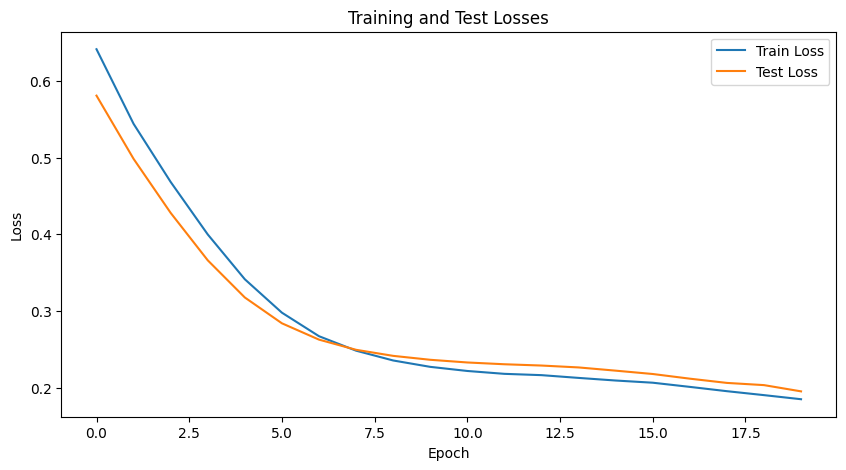

/tmp/ipykernel_19/2450132162.py:625: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))



Generating embeddings with model...
Using 2 GPUs for embedding generation!


Generating embeddings: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Using 2 GPUs for embedding generation!


Generating embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]



Comparing similarity metrics...


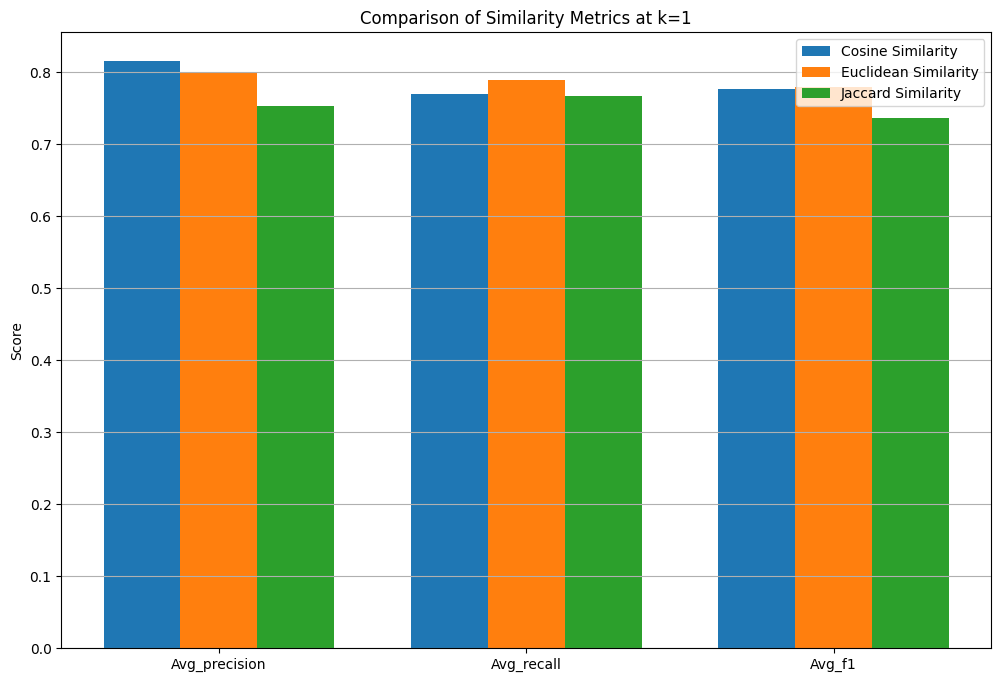

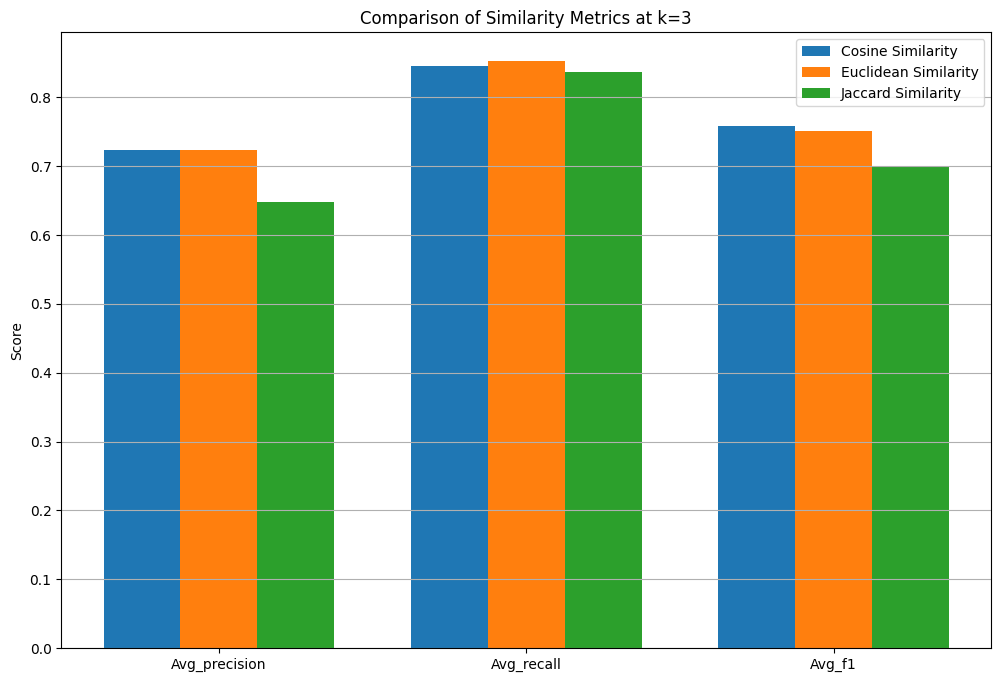

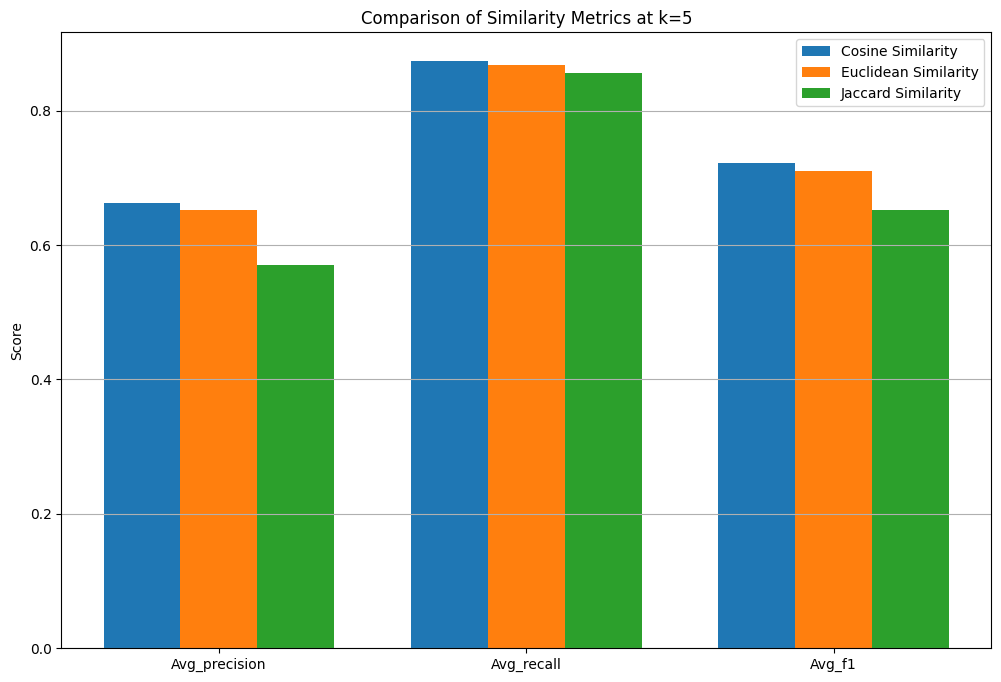

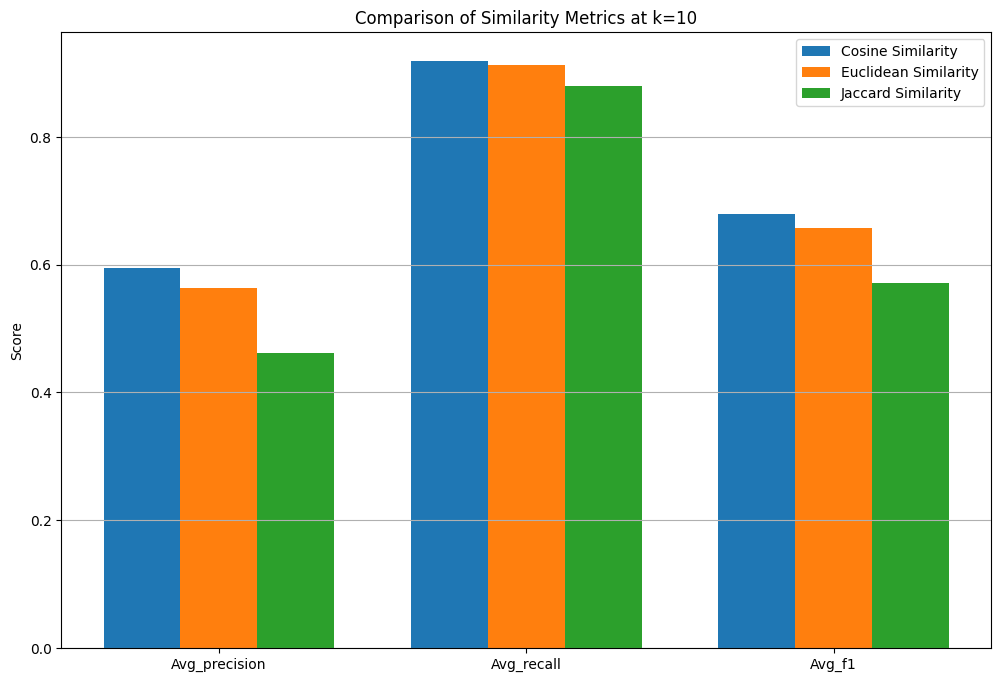


Processing results for cosine similarity...

Cosine Similarity Metrics:
Match Rate (at least one match): 0.8434
Average Precision@1: 0.8153
Average Recall@1: 0.7695
Average F1@1: 0.7764
Average Precision@3: 0.7227
Average Recall@3: 0.8452
Average F1@3: 0.7586
Average Precision@5: 0.6626
Average Recall@5: 0.8733
Average F1@5: 0.7226
Average Precision@10: 0.5941
Average Recall@10: 0.9179
Average F1@10: 0.6799
Average Label Overlap: 0.7741

Processing results for euclidean similarity...

Euclidean Similarity Metrics:
Match Rate (at least one match): 0.8434
Average Precision@1: 0.7992
Average Recall@1: 0.7896
Average F1@1: 0.7800
Average Precision@3: 0.7228
Average Recall@3: 0.8518
Average F1@3: 0.7516
Average Precision@5: 0.6529
Average Recall@5: 0.8687
Average F1@5: 0.7096
Average Precision@10: 0.5634
Average Recall@10: 0.9118
Average F1@10: 0.6573
Average Label Overlap: 0.7604

Processing results for jaccard similarity...

Jaccard Similarity Metrics:
Match Rate (at least one match): 0.

In [2]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using SBERT embeddings and similarity metrics')
    
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-feature-request-data/cleaned_data_with_changed_files.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=20,
                        help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--top_k', type=int, default=10,
                        help='Number of similar requests to find for each test sample')
    
    args, unknown = parser.parse_known_args()
    results = main(args)